# General Instructions to students:

1. There are 5 types of cells in this notebook. The cell type will be indicated within the cell.
    1. Markdown cells with problem written in it. (DO NOT TOUCH THESE CELLS) (**Cell type: TextRead**)
    2. Python cells with setup code for further evaluations. (DO NOT TOUCH THESE CELLS) (**Cell type: CodeRead**)
    3. Python code cells with some template code or empty cell. (FILL CODE IN THESE CELLS BASED ON INSTRUCTIONS IN CURRENT AND PREVIOUS CELLS) (**Cell type: CodeWrite**)
    4. Markdown cells where a written reasoning or conclusion is expected. (WRITE SENTENCES IN THESE CELLS) (**Cell type: TextWrite**)
    5. Temporary code cells for convenience and TAs. (YOU MAY DO WHAT YOU WILL WITH THESE CELLS, TAs WILL REPLACE WHATEVER YOU WRITE HERE WITH OFFICIAL EVALUATION CODE) (**Cell type: Convenience**)
    
2. You are not allowed to insert new cells in the submitted notebook.

3. You are not allowed to import any extra packages.

4. The code is to be written in Python 3.6 syntax. Latest versions of other packages maybe assumed.

5. In CodeWrite Cells, the only outputs to be given are plots asked in the question. Nothing else to be output/print. 

6. If TextWrite cells ask you to give accuracy/error/other numbers you can print them on the code cells, but remove the print statements before submitting.

7. The convenience code can be used to check the expected syntax of the functions. At a minimum, your entire notebook must run with "run all" with the convenience cells as it is. Any runtime failures on the submitted notebook as it is will get zero marks.

8. All code must be written by yourself. Copying from other students/material on the web is strictly prohibited. Any violations will result in zero marks.

9. All datasets will be given as .npz files, and will contain data in 4 numpy arrays :"X_train, Y_train, X_test, Y_test". In that order. The meaning of the 4 arrays can be easily inferred from their names.

10. All plots must be labelled properly, all tables must have rows and columns named properly.

11. Before subbmission ensure that you submit with the outputs (do not clear the outputs), so that when evaluating we can run selectively.

12. Before submission ensure that the path for the folder containing the data is "../../Data/" 


In [1]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn import svm
import matplotlib as mpl
import pandas as pd

# 1. Logistic Regression 

Write code for doing logistic regression below. Also write code for choosing best hyperparameters for each kernel type (use a part of training set as validation set). 

The range of hyperparameters is typically chosen on a log scale e.g. 1e-4, 1e-3, 1e-2... 1e3.

Write code for running in the cell after (You may be asked to demonstrate your code during the viva using this cell.)

In text cell after that report the following numbers you get by running appropriate code:

For each classification data set report the best kernel and regularisation parameters for linear, RBF and Poly kernels. (Linear has no kernel parameter.) Report the training and test zero-one error for those hyperparameters. 

For each given hyperparameter setting (kernel and regularisation) you will have to do some exploring to find the right learning rate to use in gradient descent. The optimisation learning rate is not a model hyperparameter and hence can be chosen based on just the training set. i.e. choose the learning rate for which the training loss decreases the most.

For the synthetic classification datasets (dataset_A and dataset_B) in 2-dimensions, also illustrate the learned classifier for each kernel setting. Do this in the last codeWrite cell for this question.


In [2]:
# CodeWrite 
# Write logistic regression code from scratch. Use gradient descent.
# Only write functions here

def sigmoid(X):
    X = np.clip(X, -500,500)
    Y = 1/(1+np.exp(-X))
    assert(X.shape==Y.shape)
    return Y

def kernel_function(u,v,kernel, kernel_param):
    """
    u - (d,1) shape numpy array
    v - (d,1) shape numpy array
    poly and linear already implemented
    """
    if kernel=='rbf':
        d,n = u.shape
        assert(v.shape==(d,1))
        val = np.exp(-kernel_param*(np.linalg.norm(u-v,axis=0)**2))
        assert(val.shape==(n,))
        return val
        
def get_kernel_matrix(X_tr, X_te, kernel, kernel_param):
    """
    X - (n,d) shape numpy array
    kernel - linear, poly, rbf
    kernel_param - required for poly and rbf
    """
    n, d = X_tr.shape
    m, d = X_te.shape
    assert(kernel in ['linear', 'poly', 'rbf'])
    assert(X_tr.shape[1]==X_te.shape[1])
    if kernel=='linear':
        K_matrix = X_tr @ X_te.T
        K_matrix = K_matrix/np.max(np.abs(K_matrix))
    elif kernel=='poly':
        K_matrix = np.power((1 + (X_tr @ X_te.T)),kernel_param)
        K_matrix = K_matrix/np.max(np.abs(K_matrix))
    elif kernel=='rbf':
        K_matrix = -1*np.ones(shape=(n,m))
        for j in range(m):
            u = X_tr.T
            v = X_te[j,:].T[:,np.newaxis]
            assert(u.shape==(d,n) and v.shape==(d,1))
            K_matrix[:,j] = kernel_function(u, v, kernel, kernel_param)   
    assert(K_matrix.shape==(n,m))
    return K_matrix

def loss_func(Y, alpha, K_matrix, reg_param):
    term0 = np.clip(np.multiply(-Y[:,np.newaxis],K_matrix@alpha),-500,500)
    term1 = np.log(1+ np.exp(term0))
    term2 = reg_param*(alpha.T@K_matrix@alpha)
    assert(term1.shape==(n,1))
    loss = np.sum(term1) + term2
    return loss
     
    
def train_pred_logistic_regression(X, Y, X_val, Y_val, 
                                   kernel='linear', reg_param=0., 
                                   kernel_param=1., num_iter_gd=100):
    """
    X : (n,d) shape numpy array
    Y : (n,)  shape numpy array
    X_val : (m,d) shape validation array
    Y_val : (m,) shape validation array
    X_test : (m,d) shape numpy array
    kernel = 'linear' or 'rbf' or 'poly' 
    reg_param = regularzation parameter
    num_iter_gd = number of GD iterations
    """
    lr = 0.5
    n, d = X.shape
    m, d = X_val.shape
    K_matrix = get_kernel_matrix(X, X, kernel, kernel_param)
    K_matrix_val = get_kernel_matrix(X, X_val, kernel, kernel_param)
    np.random.seed(101)
    alpha = np.random.randn(n,1)
    val_error_best = 1
    for _ in range(num_iter_gd):
        d_alpha = (np.multiply(-Y,K_matrix))@(sigmoid(np.multiply(-Y[:,np.newaxis],K_matrix@alpha)))
        reg_term = reg_param*(K_matrix@alpha)
        d_alpha += reg_term
        assert(d_alpha.shape==(n,1))
        alpha = alpha - (lr*d_alpha)
        logit = sigmoid(K_matrix.T @ alpha)
        train_preds = np.squeeze(np.sign(logit-0.5))
        assert(train_preds.shape==Y.shape)
        train_error = 1-((train_preds==Y).sum()/train_preds.shape[0])
        Y_pred = test_pred(alpha, X, Y, X_val, 
                           kernel=k, kernel_param=kernel_param, K_matrix=K_matrix_val)
        val_error = 1-((Y_pred==Y_val).sum()/Y_pred.shape[0])
        if val_error<=val_error_best:
            val_error_best = val_error
            alpha_best = alpha
            train_error_corr = train_error
    return alpha_best, train_error_corr, val_error_best
    
def test_pred(alpha, train_X, train_Y, test_X, kernel, kernel_param, K_matrix=None):
    """
    Return the predictions on test_X using the learnt alphas
    """
    if K_matrix is None:
        K_matrix = get_kernel_matrix(train_X, test_X, kernel, kernel_param)
    n, d = train_X.shape
    m, d = test_X.shape
    assert(K_matrix.shape==(n,m) and alpha.shape==(n,1))
    preds = np.sign(sigmoid(K_matrix.T @ alpha)-0.5)
    assert(preds.shape==(m,1))
    return np.squeeze(preds)

In [4]:
# CodeWrite : Use the functions above to do validation to get best hyperparameters 
# (i.e. kernel_param and regularisation_param).
# Also, get the numbers you report below. 

letters = ['A', 'B', 'C', 'D']
PATHS = ['Archive/Dataset_A.npz','Archive/Dataset_B.npz', 'Archive/Dataset_C.npz', 'Archive/Dataset_D.npz']
ROOT = '../../Data/'
PATHS = [ROOT+path for path in PATHS]
for i, path in enumerate(PATHS):
    print(f'Dataset_{letters[i]}')
    with np.load(path) as data:
        X = data['arr_0']
        Y = data['arr_1']
        X_test = data['arr_2']
        Y_test = data['arr_3']
        
    mean = np.mean(X, axis=0)
    std_old = np.std(X, axis=0)
    std = np.where(std_old!=0, std_old, 1)
    X = (X-mean)/std
    X_test = (X_test-mean)/std
    
    n, d =X.shape
    assert(Y.shape==(n,))
    xy = np.concatenate([X, Y[:,np.newaxis]], axis=1)
    assert(xy.shape==(n,d+1))
    np.random.seed(101)
    np.random.shuffle(xy)
    train_len = int(np.ceil(0.80*n))
    X_train, X_val = xy[:train_len,:d], xy[train_len:,:d]
    Y_train, Y_val = np.squeeze(xy[:train_len,d:]), np.squeeze(xy[train_len:,d:])
    assert(X_train.shape[0]+X_val.shape[0]==n)
    
    REG_PARAM = [0, 1e-5, 1e-4, 1e-3, 1e-2, 1e-1, 1]
    EPOCH = 100
    KERNEL = ['linear','poly','rbf']
    KERNEL_PARAM = {'linear':[1],
                    'rbf':[1e-5,1e-4,1e-3,1e-2,1e-1,1,10],
                    'poly':[1,2,4,8,10]
                    }
    for k in KERNEL:
        val_best = 1
        for kp in KERNEL_PARAM[k]:
            for rp in REG_PARAM:
                alpha, train_error, val_error = train_pred_logistic_regression(X_train, Y_train, X_val, Y_val,
                                                                               kernel=k, reg_param=rp,
                                                                               kernel_param=kp, num_iter_gd=EPOCH)
                Y_test_pred = test_pred(alpha,X_train,Y_train,X_test,k,kp,K_matrix=None)
                test_error = ((Y_test_pred!=Y_test).sum()/Y_test.shape[0])    
                if val_error<val_best:
                    test_best = test_error
                    alpha_best = alpha
                    val_best = val_error
                    kp_best, rp_best = kp, rp
        print('{} Kernel-->Test err-{:.4f},Val err-{:.4f}, '.format(k,test_best,val_best),end=' ')
        print('Best kernel_param-->{},reg_param-->{}'.format(kp_best, rp_best))

Dataset_A
linear Kernel-->Test err-0.1340,Val err-0.0900,  Best kernel_param-->1,reg_param-->0
poly Kernel-->Test err-0.0980,Val err-0.0500,  Best kernel_param-->4,reg_param-->0.001
rbf Kernel-->Test err-0.0060,Val err-0.0000,  Best kernel_param-->1,reg_param-->0.0001
Dataset_B
linear Kernel-->Test err-0.2000,Val err-0.2100,  Best kernel_param-->1,reg_param-->0.1
poly Kernel-->Test err-0.2020,Val err-0.1800,  Best kernel_param-->10,reg_param-->0
rbf Kernel-->Test err-0.2080,Val err-0.1800,  Best kernel_param-->1,reg_param-->0.001
Dataset_C
linear Kernel-->Test err-0.1178,Val err-0.1167,  Best kernel_param-->1,reg_param-->0.1
poly Kernel-->Test err-0.1717,Val err-0.1133,  Best kernel_param-->2,reg_param-->1
rbf Kernel-->Test err-0.0438,Val err-0.0367,  Best kernel_param-->0.1,reg_param-->0.1
Dataset_D
linear Kernel-->Test err-0.0237,Val err-0.0125,  Best kernel_param-->1,reg_param-->0
poly Kernel-->Test err-0.0237,Val err-0.0125,  Best kernel_param-->1,reg_param-->0
rbf Kernel-->Test er

TextWrite Cell: 
### Test set errors

| Kernel--> | linear | poly   | rbf    |
|-----------|--------|--------|--------|
| Dataset_A | 0.1340 | 0.0980 | **0.0060** |
| Dataset_B | **0.2000** | 0.2020 | 0.2080 |
| Dataset_C | 0.1178 | 0.1717 | **0.0438** |
| Dataset_D | 0.0237 | **0.0237** | 0.0414 |

### Observations
* For Dataset_A, rbf kernel performs much better compared to that of linear and polynomial kernels. Low regularization means there is not much noise and less chance of overfitting.
* For Dataset_B, all three kernels perform almost equally. This is because the distribution is pretty straightforward and can be split even with a straight line. The reg_param is comparitively higher showing that regularization is required because the distribution is somewhat noisy.
* For Datasets C rbf with low kernel_param gives the minimum test set error. the differemce is also high compared to linear and polynomial kernels.
* For Dataset D, linear and polynomial kernel with degree 1 give lower error compared to that of rbf kernel. 
* Normalisation is very much important. If the dataset is not normalised it gives bag score for rbf and linear kernels.
* Only 1st degree polynomial kernels are required for Dataset_B and Dataset_D. While 4th and 10th order polynomial kernels gave the best score for Dataset_C and Dataset_A.
* All the kernels are optimized so the whole training takes place in least amount of time.

### Best test accuracies
* Dataset_A - **99.40** --> rbf kernel, kernel_param=1, reg_param=0.0001
* Dataset_B - **80.00** --> linear kernel, kernel_param=1, reg_param=0.1
* Dataset_C - **95.62** --> rbf kernel, kernel_param=0.1, reg_param=0.1
* Dataset_D - **97.63** --> poly kernel, kernel_param=1, reg_param=0

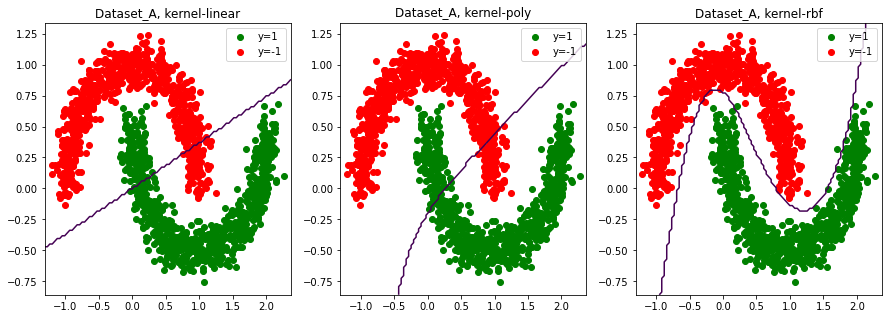

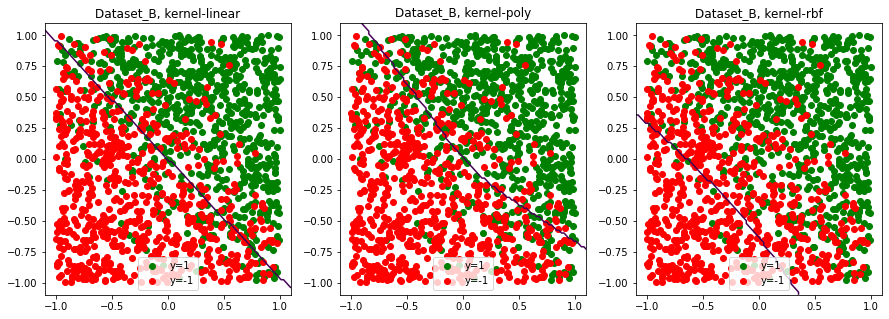

In [7]:
# Codewrite cell: Generate plots of learned classifier for all three kernel types, on dataset_A and dataset_B.
# Plots should give both the learned classifier and the train data. 
# Similar to  Bishop Figure 4.5 (with just two classes here.)
# Total number of plots = 3 * 2 = 6
PATHS = ['Archive/Dataset_A.npz','Archive/Dataset_B.npz']
ROOT = '../../Data/'
PATHS = [ROOT+path for path in PATHS]
BEST_HP = [[(1,0),(4,0.01),(1,0.0001)],[(1,0.1),(10,0),(1,0.001)]]
letters = ['A', 'B', 'C', 'D']
for i,path in enumerate(PATHS):
    with np.load(path) as data:
        X = data['arr_0']
        Y = data['arr_1']
        X_test = data['arr_2']
        Y_test = data['arr_3']
    n, d =X.shape
    assert(Y.shape==(n,))
    xy = np.concatenate([X, Y[:,np.newaxis]], axis=1)
    assert(xy.shape==(n,d+1))
    np.random.seed(101)
    np.random.shuffle(xy)
    train_len = int(np.ceil(0.80*n))
    X_train, X_val = xy[:train_len,:d], xy[train_len:,:d]
    Y_train, Y_val = np.squeeze(xy[:train_len,d:]), np.squeeze(xy[train_len:,d:])
    assert(X_train.shape[0]+X_val.shape[0]==n)
    
    KERNEL = ['linear','poly','rbf']
    fig, axs = plt.subplots(1, 3, figsize=(15,5))
    for j, k in enumerate(KERNEL):
        kp = BEST_HP[i][j][0]
        rp = BEST_HP[i][j][1]
        alpha, train_error, val_error = train_pred_logistic_regression(X_train, Y_train, X_val, Y_val,  
                                                                       kernel=k, reg_param=rp,
                                                                       kernel_param=kp, num_iter_gd=100)
        max_x1, min_x1 = np.amax(X[:,0])+0.1, np.amin(X[:,0])-0.1
        max_x2, min_x2 = np.amax(X[:,1])+0.1, np.amin(X[:,1])-0.1
        x1_dummy, x2_dummy = np.linspace(min_x1, max_x1, 100), np.linspace(min_x2, max_x2, 100)
        x1_dummy_grid, x2_dummy_grid = np.meshgrid(x1_dummy, x2_dummy)
        X_dummy_test = np.c_[x1_dummy_grid.ravel(), x2_dummy_grid.ravel()]
        dummy_pred = test_pred(alpha,X_train,Y_train,X_dummy_test,k,kp,K_matrix=None).reshape(100,100)
        axs[j].contour(x1_dummy_grid, x2_dummy_grid, dummy_pred, [0])
        axs[j].scatter(X[Y==1,0], X[Y==1,1], marker='o', color='green', label='y=1')
        axs[j].scatter(X[Y==-1,0], X[Y==-1,1], marker='o', color='red', label='y=-1')
        axs[j].set_title('Dataset_{}, kernel-{}'.format(letters[i], k))
        axs[j].legend()
    plt.show()

# 2. SVM

Write code for learning SVM below. Also write code for choosing best hyperparameters for each kernel type. You may use sklearn.svm for this purpose. (use a part of training set as validation set)

Write code for running in the cell after (You may be asked to demonstrate your code during the viva using this cell.)

In text cell after that report the following numbers you get by running appropriate code:

For each classification data set report the best kernel and regularisation parameters for linear, RBF and Poly kernels. (Linear has no kernel parameter.) Report the training and test zero-one error for those hyperparameters.

For the synthetic classification datasets in 2-dimensions, also illustrate the learned classifier for each kernel setting. Do this in the last codeWrite cell for this question.

In [2]:
# CodeWrite cell
# Write SVM classifier using SKlearn
# write only functions here
def _train_svm(X_train, Y_train, kernel, kernel_param, reg_param):
    n, d = X_train.shape
    if kernel=='rbf':
        clf = svm.SVC(C=reg_param, kernel='rbf', gamma=kernel_param)
    elif kernel=='poly':
        clf = svm.SVC(C=reg_param, kernel='poly', degree=kernel_param)
    elif kernel=='linear':
        clf = svm.SVC(C=reg_param, kernel='linear')
    else:
        raise Exception('Should be linear, rbf, or poly')
    mean = np.mean(X_train, axis=0)
    std_old = np.std(X_train, axis=0)
    std = np.where(std_old!=0, std_old, 1)
    X_train_scaled = (X_train-mean)/std
    clf.fit(X_train_scaled,Y_train)
    return clf, (mean, std)

def _pred_svm(X_test, clf, mean, std):
    X_test_scaled = (X_test-mean)/std
    Y_test_pred = clf.predict(X_test_scaled)
    return Y_test_pred

def _train_and_validate_svm(X, Y, kernel, kernel_param, reg_param):
    n, d =X.shape
    assert(Y.shape==(n,))
    xy = np.concatenate([X, Y[:,np.newaxis]], axis=1)
    assert(xy.shape==(n,d+1))
    np.random.seed(101)
    np.random.shuffle(xy)
    train_len = int(np.ceil(0.80*n))
    X_train, X_val = xy[:train_len,:d], xy[train_len:,:d]
    Y_train, Y_val = np.squeeze(xy[:train_len,d:]), np.squeeze(xy[train_len:,d:])
    assert(X_train.shape[0]+X_val.shape[0]==n)
    clf, (mean, std) = _train_svm(X_train, Y_train, kernel, kernel_param, reg_param)
    Y_val_pred = _pred_svm(X_val, clf, mean, std)
    val_error = ((Y_val_pred!=Y_val).sum()/Y_val.shape[0])
    return clf, (mean, std), val_error

In [9]:
# CodeWrite cell
# Write code here for doing validation (for kernel_param and regularisation_param)
# on a subset of the training set. 
# Also for generating the numbers that you report below.
PATHS = ['Archive/Dataset_A.npz','Archive/Dataset_B.npz','Archive/Dataset_C.npz','Archive/Dataset_D.npz']
ROOT = '../../Data/'
PATHS = [ROOT+path for path in PATHS]
letters = ['A', 'B', 'C', 'D']
for i, path in enumerate(PATHS):
    print('Dataset_{}'.format(letters[i]))
    with np.load(path) as data:
        X = data['arr_0']
        Y = data['arr_1']
        X_test = data['arr_2']
        Y_test = data['arr_3']
    REG_PARAM = [1e-4,1e-3,1e-2,1e-1,0.5,1,2,4,8,16,32,64,100]
    KERNEL = ['linear','poly','rbf']
    KERNEL_PARAM = {'linear':[1],
                    'rbf':[1e-5,1e-4,1e-3,1e-2,1e-1,0.5,1,10],
                    'poly':[1,2,4,8,10]
                   }
    for k in KERNEL:
        val_best = 1
        for kp in KERNEL_PARAM[k]:
            for rp in REG_PARAM:
                clf, (mean, std), val_error = _train_and_validate_svm(X, Y, k, kp, rp)
                Y_test_pred = _pred_svm(X_test, clf, mean, std)
                test_error = ((Y_test_pred!=Y_test).sum()/Y_test.shape[0])    
                if val_error<val_best:
                    test_best = test_error
                    val_best = val_error
                    kp_best, rp_best = kp, rp
        print('{} Kernel-->Test err-{:.4f},Val err-{:.4f}, '.format(k,test_best,val_best),end=' ')
        print('Best kernel_param-->{},reg_param-->{}'.format(kp_best, rp_best))

Dataset_A
linear Kernel-->Test err-0.1340,Val err-0.0933,  Best kernel_param-->1,reg_param-->0.1
poly Kernel-->Test err-0.1340,Val err-0.0933,  Best kernel_param-->1,reg_param-->0.5
rbf Kernel-->Test err-0.0040,Val err-0.0000,  Best kernel_param-->0.5,reg_param-->0.5
Dataset_B
linear Kernel-->Test err-0.1940,Val err-0.1867,  Best kernel_param-->1,reg_param-->0.001
poly Kernel-->Test err-0.1920,Val err-0.1867,  Best kernel_param-->1,reg_param-->0.01
rbf Kernel-->Test err-0.2000,Val err-0.1800,  Best kernel_param-->0.01,reg_param-->100
Dataset_C
linear Kernel-->Test err-0.1044,Val err-0.1033,  Best kernel_param-->1,reg_param-->0.1
poly Kernel-->Test err-0.0673,Val err-0.0100,  Best kernel_param-->4,reg_param-->8
rbf Kernel-->Test err-0.0269,Val err-0.0300,  Best kernel_param-->0.01,reg_param-->8
Dataset_D
linear Kernel-->Test err-0.0178,Val err-0.0250,  Best kernel_param-->1,reg_param-->0.01
poly Kernel-->Test err-0.0178,Val err-0.0125,  Best kernel_param-->1,reg_param-->0.1
rbf Kernel--

TextWrite Cell: 

### Test set errors

| Kernel--> | linear | poly   | rbf    |
|-----------|--------|--------|--------|
| Dataset_A | 0.1340 | 0.1340 | **0.0040** |
| Dataset_B | 0.1940 | **0.1920** | 0.2000 |
| Dataset_C | 0.1044 | 0.0673 | **0.0269** |
| Dataset_D | **0.0178** | **0.0178** | **0.0178** |

### Observations
* For Dataset_A, rbf kernel performs much better compared to that of linear kernel and polynomial kernel.
* For datset_B, all three kernels performs in a similar manner. the reg_param C is very low which means high regularisation as they are inversely proportional. This is because Dataset_B can be easily classified incorporating noise into the distribution even by a linear kernel. We can see it in the plots below.
* 'rbf' with kernel param 0.1 and 'poly' kernel with degree 4 perform best for Dataset_C. Also the reg_param is large comparitively which means not much regularization is needed and there is less chance of overfitting as in the case of Dataset_B. C is a complicated distribution as it cant be represented with linear kernel.
* 'linear' and 'poly' kernel with degree 1 performs best for Dataset_D. 'rbf' performs worst. Not sure why this happens unless we have a visualization.
* For Dataset_C and D 'rbf' kernel does best with low gamma value and high regularization C value. Low gamma value corresponds to high standard deviation.
* Datasets A, B, D can be easily classified with a 1 degree polynomial kernel but C needs a high degree polynomial kernel. Degree 4 performs best for our validation dataset.
* Normalizing the dataset is very much required before passing it to the classifier.


### Best test accuracies
* Dataset_A - **99.60** --> (rbf-gamma=0.5, reg_param=0.5)
* Dataset_B - **81.00** --> (poly-degree=1, reg_param=0.1)
* Dataset_C - **97.31** --> (rbf-gamma=0.01, reg_param=8)
* Dataset_D - **98.22** --> (linear-reg_param-0.01),(poly-degree=1, reg_param=0.1),(rbf-gamma=0.001, reg_param=2)

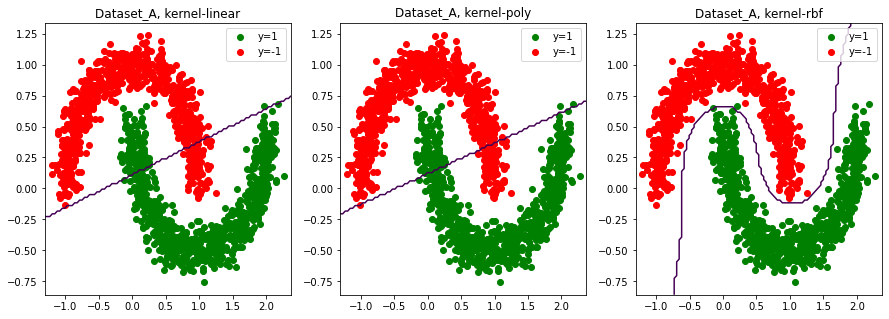

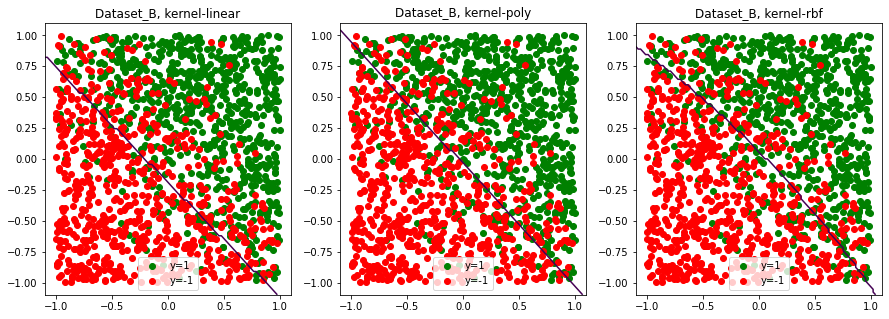

In [4]:
# Codewrite cell: Generate plots of learned classifier for all three kernel types, on dataset_A and datasset_B.
# Plots should give both the learned classifier and the train data. 
# Similar to  Bishop Figure 4.5 (with just two classes here.)
# Total number of plots = 3 * 2 = 6

PATHS = ['Archive/Dataset_A.npz','Archive/Dataset_B.npz']
ROOT = '../../Data/'
PATHS = [ROOT+path for path in PATHS]
BEST_HP = [[(1,0.1),(1,0.5),(0.5,0.5)],[(1,0.001),(1,0.01),(0.01,100)]]
letters = ['A', 'B', 'C', 'D']
for i,path in enumerate(PATHS):
    with np.load(path) as data:
        X = data['arr_0']
        Y = data['arr_1']
        X_test = data['arr_2']
        Y_test = data['arr_3']
    n, d =X.shape
    
    KERNEL = ['linear','poly','rbf']
    fig, axs = plt.subplots(1, 3, figsize=(15,5))
    for j, k in enumerate(KERNEL):
        kp = BEST_HP[i][j][0]
        rp = BEST_HP[i][j][1]
        
        clf, (mean, std), val_error = _train_and_validate_svm(X, Y, k, kp, rp)
        max_x1, min_x1 = np.amax(X[:,0])+0.1, np.amin(X[:,0])-0.1
        max_x2, min_x2 = np.amax(X[:,1])+0.1, np.amin(X[:,1])-0.1
        x1_dummy, x2_dummy = np.linspace(min_x1, max_x1, 100), np.linspace(min_x2, max_x2, 100)
        x1_dummy_grid, x2_dummy_grid = np.meshgrid(x1_dummy, x2_dummy)
        X_dummy_test = np.c_[x1_dummy_grid.ravel(), x2_dummy_grid.ravel()]
        dummy_pred = _pred_svm(X_dummy_test, clf, mean, std).reshape(100,100)
        axs[j].contour(x1_dummy_grid, x2_dummy_grid, dummy_pred, [0])
        axs[j].scatter(X[Y==1,0], X[Y==1,1], marker='o', color='green', label='y=1')
        axs[j].scatter(X[Y==-1,0], X[Y==-1,1], marker='o', color='red', label='y=-1')
        axs[j].set_title('Dataset_{}, kernel-{}'.format(letters[i], k))
        axs[j].legend()
    plt.show()

# 3. Decision Tree

Write code for learning decision tree below. Take as an argument a hyperparameter on what size node to stop splitting. Use a part of training set as validation set.

Write code for running in the cell after (You may be asked to demonstrate your code during the viva using this cell.)

In text cell after that report the following numbers you get by running appropriate code:

For all four data sets  report the best node size to stop splitting. Report the training and test zero-one error for those hyperparameters.

For datasets A and B, also illustrate the learned classifier. Do this in the last codeWrite cell for this question.

Important: Think about how you will represent a decision tree. (Possible soln: Store as a list of tuples containing node position, attribute to split, threshold, class to classifiy (if leaf node) )


In [15]:
# CodeWrite cell
# Decision Tree Classifier

class Node:
    def __init__(self, pos=None, i=None, a=None, label=None, left_branch=None, right_branch=None):
        self.pos = pos
        self.i = i
        self.a = a
        self.label = label
        self.left_branch = left_branch
        self.right_branch = right_branch
    
    def _print_node(self):
        if self.label:
            print('Leaf----> pos->{}, label->{}'.format(self.pos,self.label))
        else:
            print('Node----> pos->{}, i->{}, a->{:.4f}'.format(self.pos,self.i, self.a))
    
def _print_tree(root):
    stack = [root]
    while len(stack)!=0:
        node = stack.pop()
        node._print_node()
        if node.left_branch and node.right_branch:
            stack.append(node.left_branch)
            stack.append(node.right_branch)

def _entropy(q):
    eps = 1e-12
    q = np.clip(q,eps,1-eps)
    return (-q*np.log2(q))-((1-q)*np.log2(1-q))

def _get_min_score(X_train, Y_train, i, a, criterion):
    """
    assuming only 2 class split +1 and -1
    """
    n, d = X_train.shape
    x_left, y_left = X_train[X_train[:,i]<=a,:], Y_train[X_train[:,i]<=a]
    x_right, y_right = X_train[X_train[:,i]>a,:], Y_train[X_train[:,i]>a]
    n_left, n_right = x_left.shape[0], x_right.shape[0]
    assert(n_left+n_right==n)
    if criterion=='entropy':
        p_l, p_r = n_left/n, n_right/n
        q_l = y_left[y_left==1].shape[0]/y_left.shape[0]
        if y_right.shape[0]!=0:
            q_r = y_right[y_right==1].shape[0]/y_right.shape[0]
            score =  p_l*_entropy(q_l) + p_r*_entropy(q_r)
            return score, (x_left,y_left), (x_right, y_right), False
        else:
            q_r = 0
            score =  p_l*_entropy(q_l) + p_r*_entropy(q_r)
            return score, (x_left,y_left), (x_right, y_right), True
    elif criterion=='accuracy':
        acc_err = (y_left[y_left==-1].shape[0]+y_right[y_right==1].shape[0])/n
        score = min(acc_err,1-acc_err)
        if y_right.shape[0]!=0:
            return score, (x_left,y_left), (x_right, y_right), False
        else:
            return score, (x_left,y_left), (x_right, y_right), True
    

    
def _train_decision_tree(X, Y, num_nodes_stop, criterion, position=0):
    """ 
    condition - x_i<=a - left_branch-true, right_branch-false
    """
    n_train, d = X.shape
    min_score=float('inf');
    assert(criterion in ['accuracy', 'entropy'])
    if np.unique(Y).shape[0]==1:
        return Node(pos=position,i=None,a=None,label=np.unique(Y)[0],left_branch=None,right_branch=None)
    if Y.shape[0]<num_nodes_stop:
        val = np.sign(np.sum(Y, axis=0))
        return Node(pos=position,i=None,a=None,label=val,left_branch=None,right_branch=None)
    for i in range(d):
        values = set(X[:,i])
        for a in values:
            if criterion=='entropy':
                score, (xl,yl), (xr,yr), end= _get_min_score(X, Y, i, a, 'entropy')
            else:
                score, (xl,yl), (xr,yr), end= _get_min_score(X, Y, i, a, 'accuracy')
            if score<=min_score:
                end_best = end
                min_score = score
                i_best, a_best = i, a
                X_left, Y_left, X_right, Y_right = xl, yl, xr, yr
    accuracy = 1-min_score
    if end_best:
        val = np.sign(np.sum(Y, axis=0))
        return Node(pos=position,i=None,a=None,label=val,left_branch=None,right_branch=None)
    true_branch = _train_decision_tree(X_left, Y_left, num_nodes_stop, criterion, position+1)
    false_branch = _train_decision_tree(X_right, Y_right, num_nodes_stop, criterion, position+1)
    return Node(pos=position,i=i_best,a=a_best,label=None,left_branch=true_branch,right_branch=false_branch)
    
def _eval_decision_tree(tree, X_test):
    m, d = X_test.shape
    Y_pred = np.zeros(shape=(m,))
    for kk in range(m):
        curr_node = tree
        while curr_node.left_branch and curr_node.right_branch:
            if X_test[kk,curr_node.i]<=curr_node.a:
                curr_node = curr_node.left_branch
            else:
                curr_node = curr_node.right_branch
        Y_pred[kk] = curr_node.label
    return Y_pred

def _train_and_validate(X, Y, num_nodes_stop, criterion):
    n, d = X.shape
    assert(Y.shape==(n,))
    xy = np.concatenate([X, Y[:,np.newaxis]], axis=1)
    assert(xy.shape==(n,d+1))
    np.random.seed(101)
    np.random.shuffle(xy)
    train_len = int(np.ceil(0.80*n))
    X_train, X_val = xy[:train_len,:d], xy[train_len:,:d]
    Y_train, Y_val = np.squeeze(xy[:train_len,d:]), np.squeeze(xy[train_len:,d:])
    xy_train, xy_val = xy[:train_len,:], xy[train_len:,:]
    assert(X_train.shape[0]+X_val.shape[0]==n)
    tree = _train_decision_tree(X_train, Y_train, num_nodes_stop, criterion, position=0)
    Y_train_pred = _eval_decision_tree(tree, X_train)
    train_score = (Y_train_pred!=Y_train).sum()/Y_train.shape[0]
    Y_val_pred = _eval_decision_tree(tree, X_val)
    val_score = (Y_val_pred!=Y_val).sum()/Y_val.shape[0]
    return tree, train_score, val_score

In [3]:
# CodeWrite cell
# Write code here for doing validation to find the best hyperparameters (i.e. num_nodes_stop)
# Also Generate the numbers that you report below. 
# Repeat with criterion set to entropy also.

PATHS = ['Archive/Dataset_A.npz','Archive/Dataset_B.npz','Archive/Dataset_C.npz','Archive/Dataset_D.npz']
ROOT = '../../Data/'
PATHS = [ROOT+path for path in PATHS]
letter = ['A', 'B', 'C', 'D']
for i, path in enumerate(PATHS):
    with np.load(path) as data:
        X = data['arr_0']
        Y = data['arr_1']
        X_test = data['arr_2']
        Y_test = data['arr_3']
    CRITERION = ['accuracy','entropy']
    NUM_NODES_STOP = [1,2,4,8,16,32,64,128]
    min_error = 1
    for ct in CRITERION:
        error_stack = []
        for nns in NUM_NODES_STOP:
            tree, train_score, val_score=_train_and_validate(X, Y, num_nodes_stop=nns, criterion=ct)
            #print(train_score, val_score)
            error_stack.append((round(train_score,4), round(val_score,4)))
            if val_score<min_error:
                best_tree = tree
                best_val = min_error = val_score
                params = (ct, nns)
        train_scores_list, val_scores_list = zip(*error_stack)
    # evaluating the best tree on test set
    Y_test_pred = _eval_decision_tree(best_tree, X_test)
    test_score = (Y_test_pred!=Y_test).sum()/Y_test.shape[0]
    print('Dataset_{}, Best val score->{:.4f}, test score->{:.4f}, params->{}'.format(letter[i], best_val, test_score, params))
    #_print_tree(tree)

Dataset_A, Best val score->0.0067, test score->0.0140, params->('entropy', 1)
Dataset_B, Best val score->0.1933, test score->0.2360, params->('entropy', 128)
Dataset_C, Best val score->0.0700, test score->0.0808, params->('entropy', 1)
Dataset_D, Best val score->0.0375, test score->0.1006, params->('accuracy', 1)


TextWrite cell: 

* Evaluated for num_nodes_stop = 2^n where n is from 0 to 7.(1-128). Best scores are shown in bolds.

### Dataset_A
| Num_nodes_stop--> | 1      | 2      | 4      | 8      | 16     | 32     | 64     | 128   |
|-------------------|--------|--------|--------|--------|--------|--------|--------|-------|
| Train - accuracy | 0.083  | 0.083  | 0.083  | 0.083  | 0.083  | 0.083  | 0.083  | 0.083 |
| Test - accuracy  | 0.0567 | 0.0567 | 0.0567 | 0.0567 | 0.0567 | 0.0567 | 0.0567 | 0.083 |
| Train - entropy  | **0.0**  |0.0  |0.0  |0.0  |0.0  |0.0  |0.0  |0.0  |
| Test - entropy   | **0.0067**  |0.0067  |0.0067  |0.0067  |0.0067  |0.0067  |0.0067  |0.0067  |

### Dataset_B
| Num_nodes_stop--> | 1      | 2      | 4      | 8      | 16     | 32     | 64     | 128   |
|-------------------|--------|--------|--------|--------|--------|--------|--------|-------|
| Train - accuracy | 0.1808  |0.1808  |0.1833  |0.1833  |0.1833  |0.1833  |0.1833  |0.1833  |
| Test - accuracy  | 0.2233  |0.2233  |0.2233  |0.2233  |0.2233  |0.2233  |0.22  |0.22  |
| Train - entropy  | 0.0  |0.0  |0.0333  |0.065  |0.0992  |0.1175  |0.1425  |**0.175**  |
| Test - entropy   | 0.2533  |0.2533  |0.2433  |0.2567  |0.2533  |0.2267  |0.2133  |**0.1933**  |

### Dataset_C
| Num_nodes_stop--> | 1      | 2      | 4      | 8      | 16     | 32     | 64     | 128   |
|-------------------|--------|--------|--------|--------|--------|--------|--------|-------|
| Train - accuracy | 0.07  |0.07  |0.07  |0.0758  |0.0758  |0.0925  |0.1217  |0.1217  |
| Test - accuracy  | 0.1133  |0.1133  |0.1133  |0.1367  |0.1367  |0.1433  |0.1767  |0.1767  |
| Train - entropy  | **0.0**  |0.0  |0.0025  |0.0108  |0.0258  |0.0417  |0.0717  |0.1308  |
| Test - entropy   | **0.07**  |0.07  |0.0733  |0.08  |0.09  |0.0867  |0.0833  |0.1367  |

### Dataset_D
| Num_nodes_stop--> | 1      | 2      | 4      | 8      | 16     | 32     | 64     | 128   |
|-------------------|--------|--------|--------|--------|--------|--------|--------|-------|
| Train - accuracy | **0.025**  |0.025  |0.025  |0.025  |0.0344  |0.0344  |0.0344  |0.0375  |
| Test - accuracy  | **0.0375**  |0.0375  |0.0375  |0.0375  |0.05  |0.05  |0.05  |0.05  |
| Train - entropy  | 0.0  |0.0  |0.0031  |0.0156  |0.0219  |0.025  |0.0688  |0.0719  |
| Test - entropy   | 0.0625  |0.0625  |0.075  |0.1  |0.1  |0.0875  |0.175  |0.1625  |


### Observations
* Accuracy for cases is the best for the whole dataa and no further splitting would be possible. Entropy helps in solving this issue. The train accuracy can is always 0 for num_nodes_stop=1 and entropy criterion.
* Entropy criterion gives better results for Dataset_A, Dataset_B, Dataset_C. 
* Accuracy criterion gives better rsults for Dataset_D.
* The error increases with increase in num_nodes_stop for Datasets A, B, C. This is because these datasets are easily separable and do not contain noise which is not the case for Dataset_B. As we can see from plot below a perfect decision boundary exists for Dataset_A, thus using smaller num_nodes_stop does not change anything. But if we use num_nodes_stop=1 for Dataset_B it overfits a lot on the training data and thus increasing the validation error?
* (How to speed up? Can we vectorize evaluation function?)

### Best test accuracies
* Dataset_A --> **98.60** (criterion='entropy', num_nodes_stop=1)
* Dataset_B --> **76.40** (criterion='entropy', num_nodes_stop=128)
* Dataset_A --> **90.92** (criterion='entropy', num_nodes_stop=1)
* Dataset_A --> **89.94** (criterion='accuracy', num_nodes_stop=1)

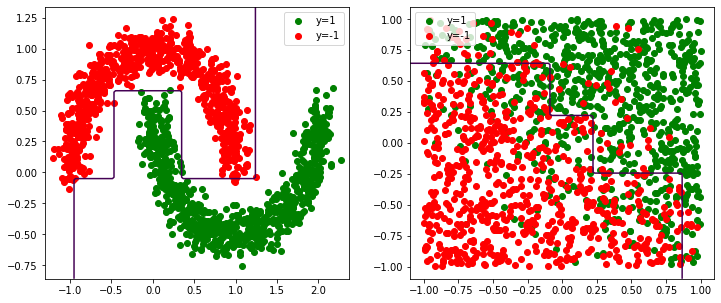

In [19]:
## Codewrite cell: Generate plots of learned decision tree classifier on dataset_A and datasset_B.
# Plots should give both the learned classifier and the train data. 
# Plots only required for the accuracy criterion.
# Similar to  Bishop Figure 4.5 (with just two classes here.)
# Total number of plots = 2 

PATHS = ['Archive/Dataset_A.npz','Archive/Dataset_B.npz']
ROOT = '../../Data/'
PATHS = [ROOT+path for path in PATHS]
NUM_NODES_STOP = [1, 128]
CRITERION = ['entropy', 'entropy']
fig, axs = plt.subplots(1, 2, figsize=(12, 5))
for i, path in enumerate(PATHS):
    with np.load(path) as data:
        X = data['arr_0']
        Y = data['arr_1']
        X_test = data['arr_2']
        Y_test = data['arr_3']
    tree, train_score, val_score =_train_and_validate(X, Y, num_nodes_stop=NUM_NODES_STOP[i], criterion=CRITERION[i])
    
    max_x1, min_x1 = np.amax(X[:,0])+0.1, np.amin(X[:,0])-0.1
    max_x2, min_x2 = np.amax(X[:,1])+0.1, np.amin(X[:,1])-0.1
    x1_dummy, x2_dummy = np.linspace(min_x1, max_x1, 100), np.linspace(min_x2, max_x2, 100)
    x1_dummy_grid, x2_dummy_grid = np.meshgrid(x1_dummy, x2_dummy)
    X_dummy_test = np.c_[x1_dummy_grid.ravel(), x2_dummy_grid.ravel()]
    dummy_pred = _eval_decision_tree(tree, X_dummy_test).reshape(100,100)
    axs[i].contour(x1_dummy_grid, x2_dummy_grid, dummy_pred, [0])
    axs[i].scatter(X[Y==1,0], X[Y==1,1], marker='o', color='green', label='y=1')
    axs[i].scatter(X[Y==-1,0], X[Y==-1,1], marker='o', color='red', label='y=-1')
    axs[i].legend()
plt.show()

# 4 Random Forest classifier

Write code for learning RandomForests below. Fix the following hyper parameters: (Fraction of data to learn tree=0.5, Fraction of number of features chosen in each node=0.5, num_nodes_stop=1).  Choose the number of trees to add in the forest by using a validation set. You may use a slightly modified version of the decision tree code you had written earlier.

Write code for running in the cell after the nest. (You may be asked to demonstrate your code during the viva using this cell.) 

In text cell after that report the following numbers you get by running appropriate code:

For all 4 data sets (A,B,C,D)  report the best number of trees found. Report the training and test zero-one error for those hyperparameters.

For the synthetic classification datasets (datasets A and B) in 2-dimensions, also illustrate the learned classifier for each kernel setting. Do this in the last codeWrite cell for this question.

In [29]:
# CodeWrite cell
# RandomForest Classifier

class Node:
    def __init__(self, pos=None, i=None, a=None, label=None, left_branch=None, right_branch=None):
        self.pos = pos
        self.i = i
        self.a = a
        self.label = label
        self.left_branch = left_branch
        self.right_branch = right_branch
    
    def _print_node(self):
        if self.label:
            print('Leaf----> pos->{}, label->{}'.format(self.pos,self.label))
        else:
            print('Node----> pos->{}, i->{}, a->{:.4f}'.format(self.pos,self.i, self.a))
    
def _print_tree(root):
    stack = [root]
    while len(stack)!=0:
        node = stack.pop()
        node._print_node()
        if node.left_branch and node.right_branch:
            stack.append(node.left_branch)
            stack.append(node.right_branch)

def _entropy(q):
    eps = 1e-12
    q = np.clip(q,eps,1-eps)
    return (-q*np.log2(q))-((1-q)*np.log2(1-q))

def _get_min_score(X_train, Y_train, i, a, criterion):
    """
    assuming only 2 class split +1 and -1
    """
    n, d = X_train.shape
    x_left, y_left = X_train[X_train[:,i]<=a,:], Y_train[X_train[:,i]<=a]
    x_right, y_right = X_train[X_train[:,i]>a,:], Y_train[X_train[:,i]>a]
    n_left, n_right = x_left.shape[0], x_right.shape[0]
    assert(n_left+n_right==n)
    if criterion=='entropy':
        p_l, p_r = n_left/n, n_right/n
        q_l = y_left[y_left==1].shape[0]/y_left.shape[0]
        if y_right.shape[0]!=0:
            q_r = y_right[y_right==1].shape[0]/y_right.shape[0]
            score =  p_l*_entropy(q_l) + p_r*_entropy(q_r)
            return score, (x_left,y_left), (x_right, y_right), False
        else:
            q_r = 0
            score =  p_l*_entropy(q_l) + p_r*_entropy(q_r)
            return score, (x_left,y_left), (x_right, y_right), True
    elif criterion=='accuracy':
        acc_err = (y_left[y_left==-1].shape[0]+y_right[y_right==1].shape[0])/n
        score = min(acc_err,1-acc_err)
        if y_right.shape[0]!=0:
            return score, (x_left,y_left), (x_right, y_right), False
        else:
            return score, (x_left,y_left), (x_right, y_right), True
    

    
def _train_decision_tree(X, Y, num_nodes_stop, criterion, position=0):
    """ 
    condition - x_i<=a - left_branch-true, right_branch-false
    """
    n_train, d = X.shape
    min_score=float('inf');
    assert(criterion in ['accuracy', 'entropy'])
    if np.unique(Y).shape[0]==1:
        return Node(pos=position,i=None,a=None,label=np.unique(Y)[0],left_branch=None,right_branch=None)
    if Y.shape[0]<num_nodes_stop:
        val = np.sign(np.sum(Y, axis=0))
        return Node(pos=position,i=None,a=None,label=val,left_branch=None,right_branch=None)
    for i in range(d):
        values = set(X[:,i])
        for a in values:
            if criterion=='entropy':
                score, (xl,yl), (xr,yr), end= _get_min_score(X, Y, i, a, 'entropy')
            else:
                score, (xl,yl), (xr,yr), end= _get_min_score(X, Y, i, a, 'accuracy')
            if score<=min_score:
                end_best = end
                min_score = score
                i_best, a_best = i, a
                X_left, Y_left, X_right, Y_right = xl, yl, xr, yr
    accuracy = 1-min_score
    if end_best:
        val = np.sign(np.sum(Y, axis=0))
        return Node(pos=position,i=None,a=None,label=val,left_branch=None,right_branch=None)
    true_branch = _train_decision_tree(X_left, Y_left, num_nodes_stop, criterion, position+1)
    false_branch = _train_decision_tree(X_right, Y_right, num_nodes_stop, criterion, position+1)
    return Node(pos=position,i=i_best,a=a_best,label=None,left_branch=true_branch,right_branch=false_branch)
    
def _eval_decision_tree(tree, X_test):
    m, d = X_test.shape
    Y_pred = np.zeros(shape=(m,))
    for kk in range(m):
        curr_node = tree
        while curr_node.left_branch and curr_node.right_branch:
            if X_test[kk,curr_node.i]<=curr_node.a:
                curr_node = curr_node.left_branch
            else:
                curr_node = curr_node.right_branch
        Y_pred[kk] = curr_node.label
    return Y_pred

def _train_random_forest(X, Y, num_trees=10, num_nodes_stop=1, 
                        criterion='accuracy', a=0.5, b=0.5):
    """ Returns a random forest trained on X and Y. 
    Trains num_trees.
    Stops splitting nodes in each tree when a node has hit a size of "num_nodes_stop" or lower.
    Split criterion can be either 'accuracy' or 'entropy'.
    Fraction of data used per tree = a
    Fraction of features used in each node = b
    Returns a random forest (In whatever format that you find appropriate)
    """
    rf_trees = []
    n, d = X.shape
    for _ in range(num_trees):
        n_shuffle, d_shuffle = np.arange(n), np.arange(d)
        np.random.shuffle(n_shuffle)
        np.random.shuffle(d_shuffle)
        n_a, d_b = int(a*n), int(b*d)
        n_shuffle = n_shuffle[:n_a]
        d_shuffle = d_shuffle[:d_b]
        X_split, Y_split = X[n_shuffle,:], Y[n_shuffle,]
        X_split = X_split[:,d_shuffle]
        assert(X_split.shape==(n_a,d_b) and Y_split.shape==(n_a,))
        tree = _train_decision_tree(X_split, Y_split, num_nodes_stop, criterion, position=0)
        rf_trees.append((tree, d_shuffle))
    return rf_trees

def _eval_random_forest(rf_trees, X_test):
    m, d = X_test.shape
    Y_pred = np.zeros(shape=(m,))
    for tree, d_shuffle in rf_trees:
        X_test_split = X_test[:,d_shuffle]
        Y_pred += _eval_decision_tree(tree, X_test_split)
    return np.sign(Y_pred)
        
def _train_and_validate_rf(X, Y, n_t, ct, a=0.5, b=0.5):
    n, d = X.shape
    assert(Y.shape==(n,))
    xy = np.concatenate([X, Y[:,np.newaxis]], axis=1)
    assert(xy.shape==(n,d+1))
    np.random.seed(101)
    np.random.shuffle(xy)
    train_len = int(np.ceil(0.80*n))
    X_train, X_val = xy[:train_len,:d], xy[train_len:,:d]
    Y_train, Y_val = np.squeeze(xy[:train_len,d:]), np.squeeze(xy[train_len:,d:])
    xy_train, xy_val = xy[:train_len,:], xy[train_len:,:]
    assert(X_train.shape[0]+X_val.shape[0]==n)
    rf_trees = _train_random_forest(X_train, Y_train, 
                                    num_trees=n_t, num_nodes_stop=1, 
                                    criterion=ct, a=a, b=b)
    Y_val_pred = _eval_random_forest(rf_trees, X_val)
    val_error = 1-(Y_val_pred==Y_val).sum()/Y_val.shape[0]
    Y_train_pred = _eval_random_forest(rf_trees, X_train)
    train_error = (Y_train_pred!=Y_train).sum()/Y_train.shape[0]
    return rf_trees, train_error, val_error

In [14]:
# CodeWrite cell
# Write code for choosing the best hyperparameters (num_trees, num_nodes_stop)
# Write code here for generating the numbers that you report below.
# Repeat above for criterion set to entropy also.
PATHS = ['Archive/Dataset_A.npz','Archive/Dataset_B.npz','Archive/Dataset_C.npz','Archive/Dataset_D.npz']
ROOT = '../../Data/'
PATHS = [ROOT+path for path in PATHS]
letters = ['A', 'B', 'C', 'D']
for i, path in enumerate(PATHS):
    with np.load(path) as data:
        X = data['arr_0']
        Y = data['arr_1']
        X_test = data['arr_2']
        Y_test = data['arr_3']
    val_error_best =1
    NUM_TREES = [1,2,3,6,8,10,15,20]
    CRITERION = ['entropy', 'accuracy']
    for ct in CRITERION:
        error_stack = []
        for n_t in NUM_TREES:
            rf_trees, train_error, val_error =_train_and_validate_rf(X, Y, n_t, ct, a=0.5, b=0.5)
            error_stack.append((train_error, val_error))
            if val_error<val_error_best:
                val_error_best = val_error
                train_error_best = train_error
                rf_best = rf_trees
                f1, f2 = ct, n_t
        train_error_list, val_error_list = zip(*error_stack)
#         for jj in train_error_list:
#             print(round(jj,4), end='  |')
#         print()
#         for jj in val_error_list:
#             print(round(jj,4), end='  |')
#         print()
    Y_test_pred = _eval_random_forest(rf_best, X_test)
    test_error = 1-(Y_test_pred==Y_test).sum()/Y_test.shape[0]
    print('Dataset_{}, Best score-> Num_trees-{}, criterion-{}'.format(letters[i],f2,f1), end=' ')  
    print('train_error->{:.4f}, val_error->{:.4f}, test_error->{:.4f}'.format(train_error_best, val_error_best, test_error))

Dataset_A, Best score-> Num_trees-15, criterion-entropy train_error->0.0067, val_error->0.0567, test_error->0.1220
Dataset_B, Best score-> Num_trees-15, criterion-accuracy train_error->0.2075, val_error->0.2333, test_error->0.2420
Dataset_C, Best score-> Num_trees-15, criterion-entropy train_error->0.0008, val_error->0.0233, test_error->0.0471
Dataset_D, Best score-> Num_trees-15, criterion-entropy train_error->0.0000, val_error->0.0250, test_error->0.0533


TextWrite cell: 

### Dataset_A
|   NUM_TREES-->    | 1      | 2      | 3      | 6      | 8      | 10     | 15     | 20    |
|-------------------|--------|--------|--------|--------|--------|--------|--------|-------|
| Train - entropy | 0.0958  |0.2042  |0.0425  |0.0475  |0.0308  |0.0233  |**0.0067**  |0.0067  |
| Val - entropy  | 0.1667  |0.39  |0.11  |0.13  |0.2  |0.0967  |**0.0567**  |0.1333  |
| Train - accuracy  | 0.1675  |0.3825  |0.1675  |0.1808  |0.1808  |0.155  |0.1383  |0.155  |
| Val - accuracy   | 0.12  |0.3167  |0.12  |0.13  |0.1267  |0.1133  |0.1033  |0.11  |

### Dataset_B
|   NUM_TREES-->    | 1      | 2      | 3      | 6      | 8      | 10     | 15     | 20    |
|-------------------|--------|--------|--------|--------|--------|--------|--------|-------|
| Train - entropy | 0.1867  |0.3558  |0.105  |0.1217  |0.0825  |0.0767  |0.0308  |0.0325  |
| Val - entropy | 0.3667  |0.62  |0.3567  |0.39  |0.4267  |0.3667  |0.3067  |0.34  |
| Train - accuracy  | 0.2783  |0.5125  |0.2767  |0.2825  |0.405  |0.2133  |**0.2075**  |0.3967  |
| Val - accuracy   | 0.2833  |0.5167  |0.2867  |0.3  |0.43  |0.24  |**0.2333**  |0.4333  |

### Dataset_C
|   NUM_TREES-->    | 1      | 2      | 3      | 6      | 8      | 10     | 15     | 20    |
|-------------------|--------|--------|--------|--------|--------|--------|--------|-------|
| Train - entropy | 0.0608  |0.0958  |0.015  |0.015  |0.0058  |0.0042  |**0.0008**  |0.0008  |
| Val - entropy  | 0.1167  |0.18  |0.0533  |0.0667  |0.0567  |0.0467  |**0.0233**  |0.0333  |
| Train - accuracy  | 0.1417  |0.2033  |0.0667  |0.1133  |0.0933  |0.0842  |0.0642  |0.0633  |
| Val - accuracy   | 0.1567  |0.25  |0.1167  |0.1633  |0.1433  |0.1367  |0.0933  |0.09  |

### Dataset_D
|   NUM_TREES-->    | 1      | 2      | 3      | 6      | 8      | 10     | 15     | 20    |
|-------------------|--------|--------|--------|--------|--------|--------|--------|-------|
| Train - entropy | 0.0344  |0.0938  |0.0188  |0.0312  |0.0094  |0.0094  |**0.0**  |0.0  |
| Val - entropy  | 0.0625  |0.175  |0.0625  |0.075  |0.0625  |0.05  |**0.025**  |0.025  |
| Train - accuracy  | 0.0406  |0.0906  |0.0344  |0.0281  |0.0312  |0.0312  |0.0219  |0.025  |
| Val - accuracy  | 0.0875  |0.1125  |0.075  |0.075  |0.0625  |0.0625  |0.0375  |0.05  |

### Observations
* The errors of datasets A and B decreased because they both have only 2 features. So when we split with b=0.5 each tree in the random forest is allowed to train only on 1 feature which makes it bad.
* The more the number of features and number of samples train set, the better the performance of RandomForestClassifier. 
* Similarly it is not a good idea to use randomforest classifier if number of features or the training sample size is too low. 
* All datasets gave best validation scores when num_trees=15. Too many trees and too less trees as well can be bad for the classifier.

### Best test accuracies
* Dataset_A --> **87.80** (criterion='entropy', num_nodes_stop=1) - decreased 10%
* Dataset_B --> **75.80** (criterion='entropy', num_nodes_stop=128) - decreased 1%
* Dataset_A --> **95.39** (criterion='entropy', num_nodes_stop=1) - increased 5%
* Dataset_A --> **94.67** (criterion='accuracy', num_nodes_stop=1) - increased 5%

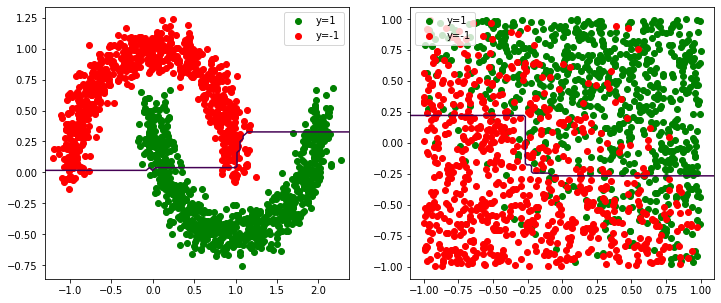

In [30]:
## Codewrite cell: Generate plots of learned Random Forest classifier on dataset_A and datasset_B.
# Plots should give both the learned classifier and the train data. 
# Plots required only for the accuracy criterion.
# Similar to  Bishop Figure 4.5 (with just two classes here.)
# Total number of plots = 2 

PATHS = ['Archive/Dataset_A.npz','Archive/Dataset_B.npz']
ROOT = '../../Data/'
PATHS = [ROOT+path for path in PATHS]
NUM_TREES = [15, 15]
CRITERION = ['accuracy', 'accuracy']
fig, axs = plt.subplots(1, 2, figsize=(12, 5))
for i, path in enumerate(PATHS):
    with np.load(path) as data:
        X = data['arr_0']
        Y = data['arr_1']
        X_test = data['arr_2']
        Y_test = data['arr_3']
    rf_trees, train_score, val_score =_train_and_validate_rf(X, Y, n_t=NUM_TREES[i], ct=CRITERION[i])
    
    max_x1, min_x1 = np.amax(X[:,0])+0.1, np.amin(X[:,0])-0.1
    max_x2, min_x2 = np.amax(X[:,1])+0.1, np.amin(X[:,1])-0.1
    x1_dummy, x2_dummy = np.linspace(min_x1, max_x1, 100), np.linspace(min_x2, max_x2, 100)
    x1_dummy_grid, x2_dummy_grid = np.meshgrid(x1_dummy, x2_dummy)
    X_dummy_test = np.c_[x1_dummy_grid.ravel(), x2_dummy_grid.ravel()]
    dummy_pred = _eval_random_forest(rf_trees, X_dummy_test).reshape(100,100)
    axs[i].contour(x1_dummy_grid, x2_dummy_grid, dummy_pred, [0])
    axs[i].scatter(X[Y==1,0], X[Y==1,1], marker='o', color='green', label='y=1')
    axs[i].scatter(X[Y==-1,0], X[Y==-1,1], marker='o', color='red', label='y=-1')
    axs[i].legend()
plt.show()

# 5 AdaBoost

Write code for learning using AdaBoost below. Use 3 different weak learners below. (You may reuse code written above)

1. 1 node decision tree 
2. Decision tree of fixed depth = 3 (Root, child, grand child)
3. Decision tree of fixed depth = 7 (Root, child, grand child)

Run for 50 iterations. You may use the accuracy split criterion for all the three weak learners.

Write code for running in the next cell. (You may be asked to demonstrate your code during the viva using this cell.) 

In text cell after that report the following numbers you get by running appropriate code:

For all 4 data sets (A,B,C,D)  plot the train and test accuracy vs epochs. A total of 12 plots is expected. 4 datasets * 3 weak learners. Each plot should contain two curves, train and test error.  

For the synthetic classification datasets (datasets A and B) in 2-dimensions, also illustrate the learned classifier for each weak learner setting. A total of 6 contourf style plots are expected here. Do this in the last codeWrite cell for this question.

Summarise your observations in the last textwrite cell.

In [24]:
# Codewrite cell
# Write code to run here (no plotting)
class Node:
    def __init__(self, pos=None, i=None, a=None, label=None, left_branch=None, right_branch=None):
        self.pos = pos
        self.i = i
        self.a = a
        self.label = label
        self.left_branch = left_branch
        self.right_branch = right_branch
    
    def _print_node(self):
        if self.label:
            print('Leaf----> pos->{}, label->{}'.format(self.pos,self.label))
        else:
            print('Node----> pos->{}, i->{}, a->{:.4f}'.format(self.pos,self.i, self.a))
                    
def _print_tree(root):
    stack = [root]
    while len(stack)!=0:
        node = stack.pop()
        node._print_node()
        if node.left_branch and node.right_branch:
            stack.append(node.left_branch)
            stack.append(node.right_branch)
            
def _entropy(q):
    eps = 1e-12
    q = np.clip(q,eps,1-eps)
    return (-q*np.log2(q))-((1-q)*np.log2(1-q))

def _get_min_score_adaboost(X_train, Y_train, i, a, criterion, weight):
    """
    assuming only 2 class split +1 and -1
    added weighted score to the accuracy classifier
    """
    n, d = X_train.shape
    assert(weight.shape==(n,))
    x_left, y_left = X_train[X_train[:,i]<=a,:], Y_train[X_train[:,i]<=a]
    x_right, y_right = X_train[X_train[:,i]>a,:], Y_train[X_train[:,i]>a]
    weight_left, weight_right = weight[X_train[:,i]<=a], weight[X_train[:,i]>a]
    n_left, n_right = x_left.shape[0], x_right.shape[0]
    assert(n_left+n_right==n)
    if criterion=='entropy':
        p_l, p_r = n_left/n, n_right/n
        q_l = y_left[y_left==1].shape[0]/y_left.shape[0]
        if y_right.shape[0]!=0:
            q_r = y_right[y_right==1].shape[0]/y_right.shape[0]
            score =  p_l*_entropy(q_l) + p_r*_entropy(q_r)
            return score, (x_left,y_left), (x_right, y_right), False
        else:
            q_r = 0
            score =  p_l*_entropy(q_l) + p_r*_entropy(q_r)
            return score, (x_left,y_left), (x_right, y_right), True
    elif criterion=='accuracy':
        #acc_err = (y_left[y_left==-1].shape[0]+y_right[y_right==1].shape[0])/n
        acc_err = np.sum(weight_left[y_left==-1])+np.sum(weight_right[y_right==1])
        score = min(acc_err,1-acc_err)
        if y_right.shape[0]!=0:
            return score, (x_left,y_left), (x_right, y_right), (weight_left, weight_right), False
        else:
            return score, (x_left,y_left), (x_right, y_right), (weight_left, weight_right), True
            
def _train_decision_tree_adaboost(X, Y, num_nodes_stop, criterion, max_depth, weight, position=0):
    """ 
    condition - x_i<=a - left_branch-true, right_branch-false
    additional parameter max_depth and weights
    """
    n_train, d = X.shape
    min_score=float('inf');
    assert(criterion in ['accuracy', 'entropy'])
    if np.unique(Y).shape[0]==1:
        return Node(pos=position,i=None,a=None,label=np.unique(Y)[0],left_branch=None,right_branch=None)
    if Y.shape[0]<num_nodes_stop:
        val = np.sign(np.sum(Y, axis=0)+1e-6)
        return Node(pos=position,i=None,a=None,label=val,left_branch=None,right_branch=None)
    if position>=max_depth:
        val = np.sign(np.sum(Y, axis=0)+1e-6)
        return Node(pos=position,i=None,a=None,label=val,left_branch=None,right_branch=None)
    for i in range(d):
        values = set(X[:,i])
        for a in values:
            if criterion=='entropy':
                score, (xl,yl), (xr,yr), (wl,wr), end= _get_min_score_adaboost(X, Y, i, a, 'entropy', weight)
            else:
                score, (xl,yl), (xr,yr), (wl,wr), end= _get_min_score_adaboost(X, Y, i, a, 'accuracy', weight)
            if score<=min_score:
                end_best = end
                min_score = score
                i_best, a_best = i, a
                X_left, Y_left, X_right, Y_right = xl, yl, xr, yr
                weight_left, weight_right = wl, wr
    accuracy = 1-min_score
    if end_best:
        val = np.sign(np.sum(Y, axis=0)+1e-6)
        return Node(pos=position,i=None,a=None,label=val,left_branch=None,right_branch=None)
    true_branch = _train_decision_tree_adaboost(X_left, Y_left, 
                                                num_nodes_stop, criterion, 
                                                max_depth, weight_left,
                                                position+1)
    false_branch = _train_decision_tree_adaboost(X_right, Y_right, 
                                                 num_nodes_stop, criterion,
                                                 max_depth, weight_right,
                                                 position+1)
    return Node(pos=position,i=i_best,a=a_best,label=None,left_branch=true_branch,right_branch=false_branch)
    
def _eval_decision_tree_adaboost(tree, X_test):
    m, d = X_test.shape
    Y_pred = np.zeros(shape=(m,))
    for kk in range(m):
        curr_node = tree
        while curr_node.left_branch and curr_node.right_branch:
            if X_test[kk,curr_node.i]<=curr_node.a:
                curr_node = curr_node.left_branch
            else:
                curr_node = curr_node.right_branch
        assert(curr_node.label in [1,-1])
        Y_pred[kk] = curr_node.label
    return Y_pred

def _train_adaboost(X_train, Y_train, X_val, Y_val, num_nodes_stop, criterion, max_depth):
    n, d = X_train.shape
    m, d = X_val.shape
    weight = np.ones(shape=(n,))/n
    adaboost_trees = []
    error_stack = []
    for epoch in range(50):
        tree = _train_decision_tree_adaboost(X_train, Y_train, num_nodes_stop, criterion, max_depth, weight, position=0)
        Y_train_pred = _eval_decision_tree_adaboost(tree, X_train)
        miss_error = np.sum(weight[Y_train_pred!=Y_train])+1e-6
        alpha = 0.5*np.log((1-miss_error)/miss_error)
        weight = weight*np.exp(-alpha*Y_train_pred*Y_train)
        weight = weight/np.sum(weight)
        assert(weight.shape==(n,) and 0.99<np.sum(weight)<1.01)
        train_0_1_err = np.sum(Y_train_pred!=Y_train)/n
        Y_val_pred = _eval_decision_tree_adaboost(tree, X_val)
        val_0_1_err = np.sum(Y_val_pred!=Y_val)/m
        error_stack.append((train_0_1_err, val_0_1_err))
        adaboost_trees.append((tree,alpha))
    return adaboost_trees, error_stack

def _eval_adaboost(adaboost_trees, X_test):
    m, d = X_test.shape
    Y_pred = np.zeros(shape=(m,))
    for tree, alpha in adaboost_trees:
        Y_pred += _eval_decision_tree_adaboost(tree, X_test)*alpha
    return np.sign(Y_pred)

def _train_and_validate_adaboost(X, Y, m_d):
    val_error_best =1
    n, d = X.shape
    assert(Y.shape==(n,))
    xy = np.concatenate([X, Y[:,np.newaxis]], axis=1)
    assert(xy.shape==(n,d+1))
    np.random.seed(101)
    np.random.shuffle(xy)
    train_len = int(np.ceil(0.80*n))
    X_train, X_val = xy[:train_len,:d], xy[train_len:,:d]
    Y_train, Y_val = np.squeeze(xy[:train_len,d:]), np.squeeze(xy[train_len:,d:])
    xy_train, xy_val = xy[:train_len,:], xy[train_len:,:]
    assert(X_train.shape[0]+X_val.shape[0]==n)
    adaboost_trees, error_stack = _train_adaboost(X_train, Y_train, X_val, Y_val,
                                                  num_nodes_stop=1, criterion='accuracy',
                                                  max_depth=m_d)
    Y_val_pred = _eval_adaboost(adaboost_trees, X_val)
    val_error = 1-(Y_val_pred==Y_val).sum()/Y_val.shape[0]
    return adaboost_trees, val_error, error_stack

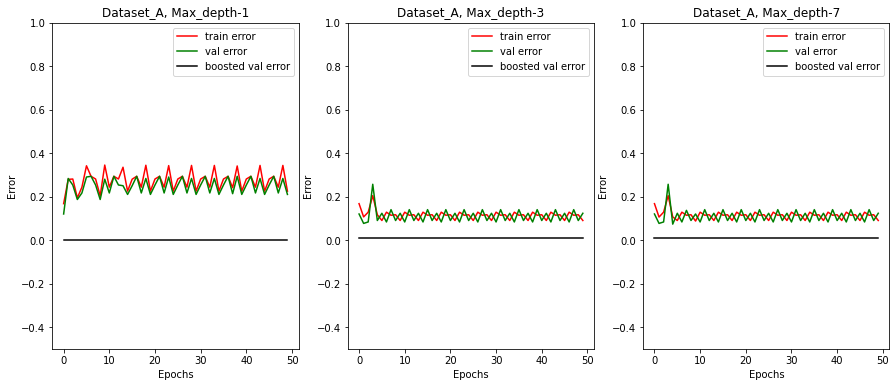

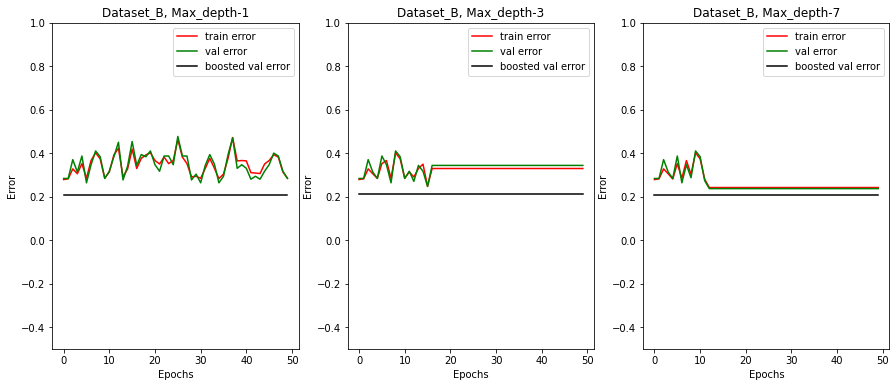

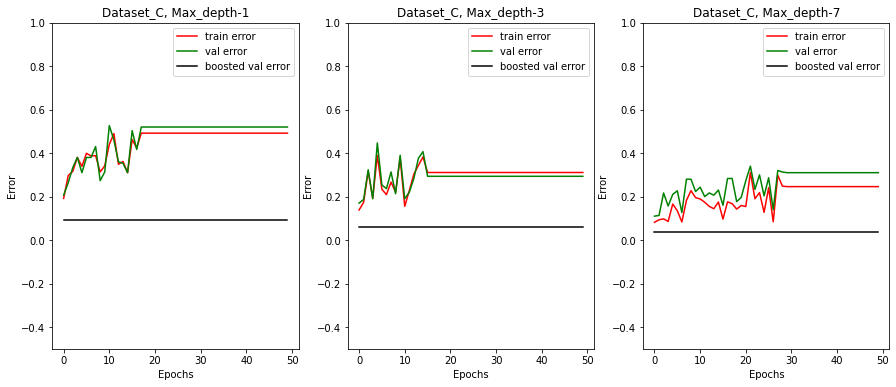

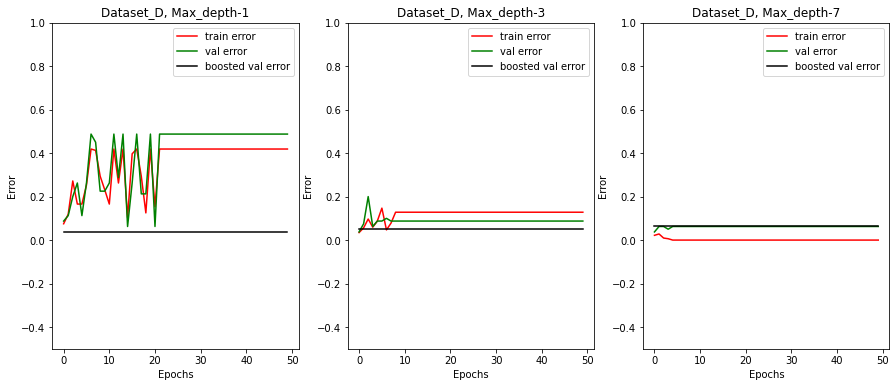

In [60]:
# Codewrite cell 
# Plots for iteration vs error here

PATHS = ['Archive/Dataset_A.npz','Archive/Dataset_B.npz','Archive/Dataset_C.npz','Archive/Dataset_D.npz']
ROOT = '../../Data/'
PATHS = [ROOT+path for path in PATHS]
letters = ['A', 'B', 'C', 'D']
for ii, path in enumerate(PATHS):
    with np.load(path) as data:
        X = data['arr_0']
        Y = data['arr_1']
        X_test = data['arr_2']
        Y_test = data['arr_3']
    MAX_DEPTH = [1,3,7]
    min_error = 1
    fig,axs = plt.subplots(1, len(MAX_DEPTH), figsize=(15,6))
    for jj, m_d in enumerate(MAX_DEPTH):
        adaboost_trees, val_error, error_stack =_train_and_validate_adaboost(X, Y, m_d)
        train_errors_list, val_errors_list = zip(*error_stack)
        axs[jj].plot(np.arange(50), train_errors_list,'-r',color='red', label='train error')
        axs[jj].plot(np.arange(50), val_errors_list,'-r',color='green', label='val error')
        axs[jj].plot([0,49], [val_error]*2,'-r',color='black', label='boosted val error')
        ds_name = 'Dataset_' + letters[ii]
        axs[jj].set_title('{}, Max_depth-{}'.format(ds_name, m_d))
        axs[jj].set_xlabel('Epochs')
        axs[jj].set_ylabel('Error')
        axs[jj].set_ylim([-0.5,1])
        axs[jj].legend()
        if val_error<min_error:
            val_error_best = min_error = val_error
            adaboost_best = adaboost_trees
            params = m_d
        #print('Max_depth-{}, val_error--> {:.4f}'.format(m_d,val_error))
    plt.show()

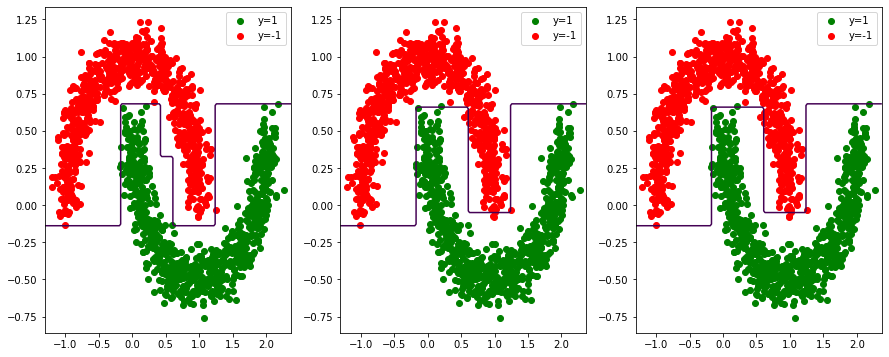

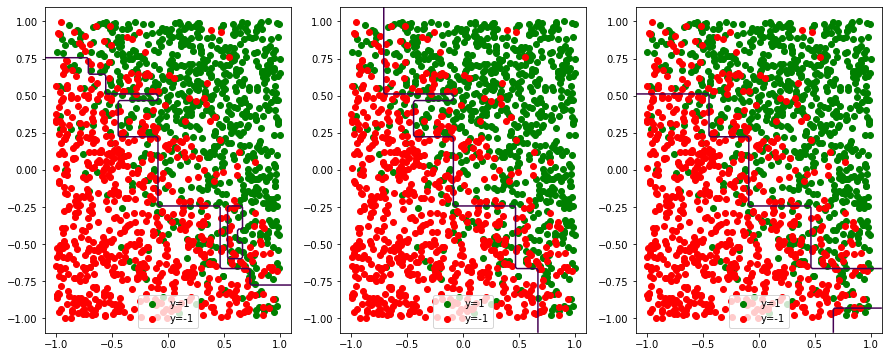

In [26]:
# Codewrite cell 
# Plots for illustrating the classifier here

PATHS = ['Archive/Dataset_A.npz','Archive/Dataset_B.npz']
ROOT = '../../Data/'
PATHS = [ROOT+path for path in PATHS]
for ii, path in enumerate(PATHS):
    with np.load(path) as data:
        X = data['arr_0']
        Y = data['arr_1']
        X_test = data['arr_2']
        Y_test = data['arr_3']
    MAX_DEPTH = [1,3,7]
    min_error = 1
    fig,axs = plt.subplots(1, len(MAX_DEPTH), figsize=(15,6))
    for jj, m_d in enumerate(MAX_DEPTH):
        adaboost_trees, val_error, error_stack =_train_and_validate_adaboost(X, Y, m_d)
        train_errors_list, val_errors_list = zip(*error_stack)
        max_x1, min_x1 = np.amax(X[:,0])+0.1, np.amin(X[:,0])-0.1
        max_x2, min_x2 = np.amax(X[:,1])+0.1, np.amin(X[:,1])-0.1
        x1_dummy, x2_dummy = np.linspace(min_x1, max_x1, 100), np.linspace(min_x2, max_x2, 100)
        x1_dummy_grid, x2_dummy_grid = np.meshgrid(x1_dummy, x2_dummy)
        X_dummy_test = np.c_[x1_dummy_grid.ravel(), x2_dummy_grid.ravel()]
        dummy_pred = _eval_adaboost(adaboost_trees, X_dummy_test).reshape(100,100)
        axs[jj].contour(x1_dummy_grid, x2_dummy_grid, dummy_pred, [0])
        axs[jj].scatter(X[Y==1,0], X[Y==1,1], marker='o', color='green', label='y=1')
        axs[jj].scatter(X[Y==-1,0], X[Y==-1,1], marker='o', color='red', label='y=-1')
        axs[jj].legend()
        if val_error<min_error:
            val_error_best = min_error = val_error
            adaboost_best = adaboost_trees
            params = m_d
        Y_test_pred = _eval_adaboost(adaboost_trees, X_test)
        test_error = 1-(Y_test_pred==Y_test).sum()/Y_test.shape[0]
        #print('Max_depth-{}, val_error--> {:.4f}, test_error--> {:.4f}'.format(m_d,val_error, test_error))
    plt.show()

Textwrite cell:
### Validation error table
| Max_Depth--> | 1      | 3      | 7      |
|--------------|--------|--------|--------|
| Dataset_A    | 0.0000 | 0.0100 | 0.0100 |
| Dataset_B    | 0.2067 | 0.2133 | 0.2067 |
| Dataset_C    | 0.0933 | 0.0600 | 0.0367 |
| Dataset_D    | 0.0375 | 0.0500 | 0.0710 |

### Test error Table
| Max_Depth--> | 1      | 3      | 7      |
|--------------|--------|--------|--------|
| Dataset_A    | 0.0120 | 0.0120 | 0.0120 |
| Dataset_B    | 0.2160 | 0.2140 | 0.2200 |
| Dataset_C    | 0.1145 | 0.0774 | 0.0505 |
| Dataset_D    | 0.0769 | 0.0710 | 0.1065 |

### Observations
* The stump error almost remains almost same for all stumps. But after boosting the the validation and test error decreases.
* For Dataset_A, dataset_B, Dataset_D using decision trees of max-dapth 1 gives similar or better results compared to that of boosting of decision trees with max depth of 3 and 7. This is because combining weaker learners help prevent the possibilities of overfitting.
* Boosting a weak learner gives much better results compared to using a single decision tree which is much deeper.
* Dataset_B has a lot of noise and is thus difficult to classify with higher decision tree depth as well.
* For Dataset_C using higher depth decreases the test error and validation error by a significant amount. 

### Best test accuracies
* Dataset_A --> **98.80** (max_depth=1)
* Dataset_B --> **78.60** (max_depth=3)
* Dataset_C --> **94.95** (max_depth=7)(decreased 1% from rf)
* Dataset_D --> **92.90** (max_depth=3)(decreased 2% from rf)

## BEST CLASSIFIER SVM vs LOGISTIC REGRESSION
* Dataset_A --> Logistic regression with rbf, SVM with rbf - **99.60**
* Dataset_B --> Logistic Regression with poly/linear/rbf, SVM with poly/linear/rbf - **81.00**
* Dataset_C --> SVM with rbf - **97.31**
* Dataset_A --> SVM with rbf/poly/linear - **98.22**

## BEST CLASSIFIER DECISION TREES vs RANDOM FOREST vs ADABOOST
* Dataset_A --> Adaboost, max_depth=1 - **98.80**
* Dataset_B --> Adaboost, max_depth=3 - **78.60**
* Dataset_C --> RandomForest, num_nodes_stop=1 - **95.39**
* Dataset_D --> RandomForest, num_nodes_stop=1 - **94.67**

* --> Everything optimized except evaluation function of decision trees.
* --> Each part takes max up to 5 minutes.

<h3 style="text-align:center">Thank You</h3>